<center>
<img src="../../img/ods_stickers.jpg">


[Материал разработат на основе электронного ресурса](Ю.Кашницкого.https://mlcourse.ai/book/index.html)

In [1]:
# <center> Модели классификации Pandas и Scikit-Learn.
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**При выполнении задания ответьте на вопросы**

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [3]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [14]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

try:
    train_df_orig = pd.read_csv("titanic_train.csv")
except FileNotFoundError:
    print("Файл 'titanic_train.csv' не найден.")
    train_df_orig = pd.DataFrame()

if not train_df_orig.empty:
    train_df = train_df_orig.copy()
    y = train_df["Survived"]

    train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
    train_df['Embarked'] = train_df['Embarked'].fillna('S')
    train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].median())

    train_df = pd.concat([train_df, pd.get_dummies(train_df['Pclass'], prefix="PClass"),
                          pd.get_dummies(train_df['Sex'], prefix="Sex"),
                          pd.get_dummies(train_df['SibSp'], prefix="SibSp"),
                          pd.get_dummies(train_df['Parch'], prefix="Parch"),
                          pd.get_dummies(train_df['Embarked'], prefix="Embarked")], axis=1)

    train_df.drop(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True, errors='ignore')

    tree = DecisionTreeClassifier(max_depth=2, random_state=17)
    tree.fit(train_df, y)

    print("Дерево решений успешно обучено.")
else:
    print("Обучение не выполнено из-за отсутствия данных.")

Дерево решений успешно обучено.


**Сделайте с помощью полученной модели прогноз для тестовой выборки **

Метрики на валидационном наборе:
Accuracy: 0.7537

Матрица ошибок на валидационном наборе:


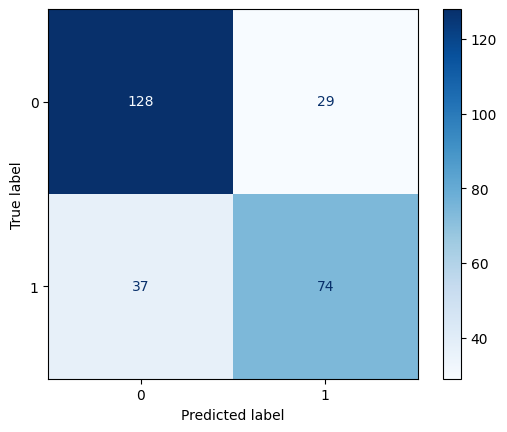


Ячейка 2: Финальный прогноз для тестовой выборки сделан.


In [15]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

try:
    train_df_orig = pd.read_csv("titanic_train.csv")
    test_df_orig = pd.read_csv("titanic_test.csv")
except FileNotFoundError:
    print("Не удалось найти файлы 'titanic_train.csv' или 'titanic_test.csv'.")
    train_df_orig, test_df_orig = pd.DataFrame(), pd.DataFrame()

if not train_df_orig.empty and not test_df_orig.empty:
    X = train_df_orig.copy()
    y = X["Survived"]
    X_test = test_df_orig.copy()

    age_median = X['Age'].median()
    fare_median = X['Fare'].median()

    X['Age'] = X['Age'].fillna(age_median)
    X['Embarked'] = X['Embarked'].fillna('S')

    X_test['Age'] = X_test['Age'].fillna(age_median)
    X_test['Fare'] = X_test['Fare'].fillna(fare_median)

    X = pd.concat([X, pd.get_dummies(X['Pclass'], prefix="PClass"),
                      pd.get_dummies(X['Sex'], prefix="Sex"),
                      pd.get_dummies(X['SibSp'], prefix="SibSp"),
                      pd.get_dummies(X['Parch'], prefix="Parch"),
                      pd.get_dummies(X['Embarked'], prefix="Embarked")], axis=1)

    X_test = pd.concat([X_test, pd.get_dummies(X_test['Pclass'], prefix="PClass"),
                         pd.get_dummies(X_test['Sex'], prefix="Sex"),
                         pd.get_dummies(X_test['SibSp'], prefix="SibSp"),
                         pd.get_dummies(X_test['Parch'], prefix="Parch"),
                         pd.get_dummies(X_test['Embarked'], prefix="Embarked")], axis=1)

    X.drop(['Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True, errors='ignore')
    X_test.drop(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True, errors='ignore')

    train_cols = X.columns
    test_cols_to_drop = set(X_test.columns) - set(train_cols)
    if test_cols_to_drop:
        X_test.drop(list(test_cols_to_drop), axis=1, inplace=True)

    missing_cols_in_test = set(train_cols) - set(X_test.columns)
    for c in missing_cols_in_test:
        X_test[c] = 0

    X_test = X_test[train_cols]

    X_train_split, X_valid, y_train_split, y_valid = train_test_split(X, y, test_size=0.3, random_state=17)

    tree_for_validation = DecisionTreeClassifier(max_depth=2, random_state=17)
    tree_for_validation.fit(X_train_split, y_train_split)

    valid_pred = tree_for_validation.predict(X_valid)

    print("Метрики на валидационном наборе:")
    print(f"Accuracy: {accuracy_score(y_valid, valid_pred):.4f}")

    cm = confusion_matrix(y_valid, valid_pred)
    print("\nМатрица ошибок на валидационном наборе:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    tree = DecisionTreeClassifier(max_depth=2, random_state=17)
    tree.fit(X, y)
    test_pred = tree.predict(X_test)
    print("\nЯчейка 2: Финальный прогноз для тестовой выборки сделан.")
else:
    test_pred = np.array([])
    print("Предсказание не выполнено из-за отсутствия данных.")